#### Let's start by breaking down the process step-by-step and proceed with the actual implementation. We'll use the kddcup.data_10_percent.gz file as you've suggested and focus on the DeepWalk technique for graph embeddings.

# Step 1: Load the Data and Basic Preprocessing

Before we can transform the dataset into a graph structure, we need to load it into our environment and perform basic preprocessing. This includes:

1. Loading the data from the compressed file.
2. Assigning appropriate column names.
3. Handling any missing values or other data irregularities.


In [1]:
# Imports
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

In [2]:
# Define column names based on the kddcup.names file
column_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

# Load the data
data = pd.read_csv('data/kddcup.data_10_percent.gz', compression='gzip', header=None, names=column_names)

# Display the first few rows of the dataset
data.head()

duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3                     1.0                     0.0   
4                     1.0                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   
1                         0.05                          0.0   
2                         0.03                          0.0   
3                         0.03                          0.0   
4                         0.02                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   
1                   0.0                       0.0                   0.0   
2                   0.0                       0.0                   0.0   
3                   0.0                       0.0                   0.0   
4                   0.0                       0.0                   0.0   

   dst_host_srv_rerror_rate    label  
0                       0.0  normal.  
1                       0.0  normal.  
2                       0.0  normal.  
3                       0.0  normal.  
4                       0.0  normal.  

[5 rows x 42 columns]

The data has been successfully loaded, and the appropriate column names have been assigned.

Now, let's move on to the next step:

# Step 2: Convert Dataset to Graph Structure

To represent the dataset as a graph:

**Nodes**: We can consider each unique combination of `protocol_type`, `service`, and `flag` as a node. This will capture the nature of the connection.

**Edges**: An edge can be drawn between nodes based on the `src_bytes` or `dst_bytes` transferred. For simplicity, we can consider each record in the dataset as an edge between two nodes defined by their `protocol_type`, `service`, and `flag`.

For the sake of visualization and processing efficiency, we'll first create a sample graph using a subset of the data. After verifying the graph structure, we can scale it up.

Let's create this graph using the networkx library.

In [3]:
# Create a directed graph
G = nx.DiGraph()

# Subset the data for initial visualization and processing (using the first 1000 records)
subset_data = data.head(1000)

# Add edges to the graph based on the records in the dataset
for index, row in subset_data.iterrows():
    source = (row["protocol_type"], row["service"], row["flag"])
    target = (row["protocol_type"], row["service"], row["flag"])  # same as source since we're defining nodes in this manner
    G.add_edge(source, target, weight=row["src_bytes"])  # using src_bytes as weight for simplicity

# Number of nodes and edges in the graph
len(G.nodes()), len(G.edges())

(10, 10)

The graph has been successfully constructed with 10 unique nodes and 10 edges based on the first 1000 records from the dataset. Each node represents a unique combination of protocol_type, service, and flag. Since we're using these attributes to define both the source and target of an edge, it's expected that the number of nodes and edges are the same in this sample graph.

For a clearer understanding, let's visualize this graph to see how the nodes and edges are structured.m

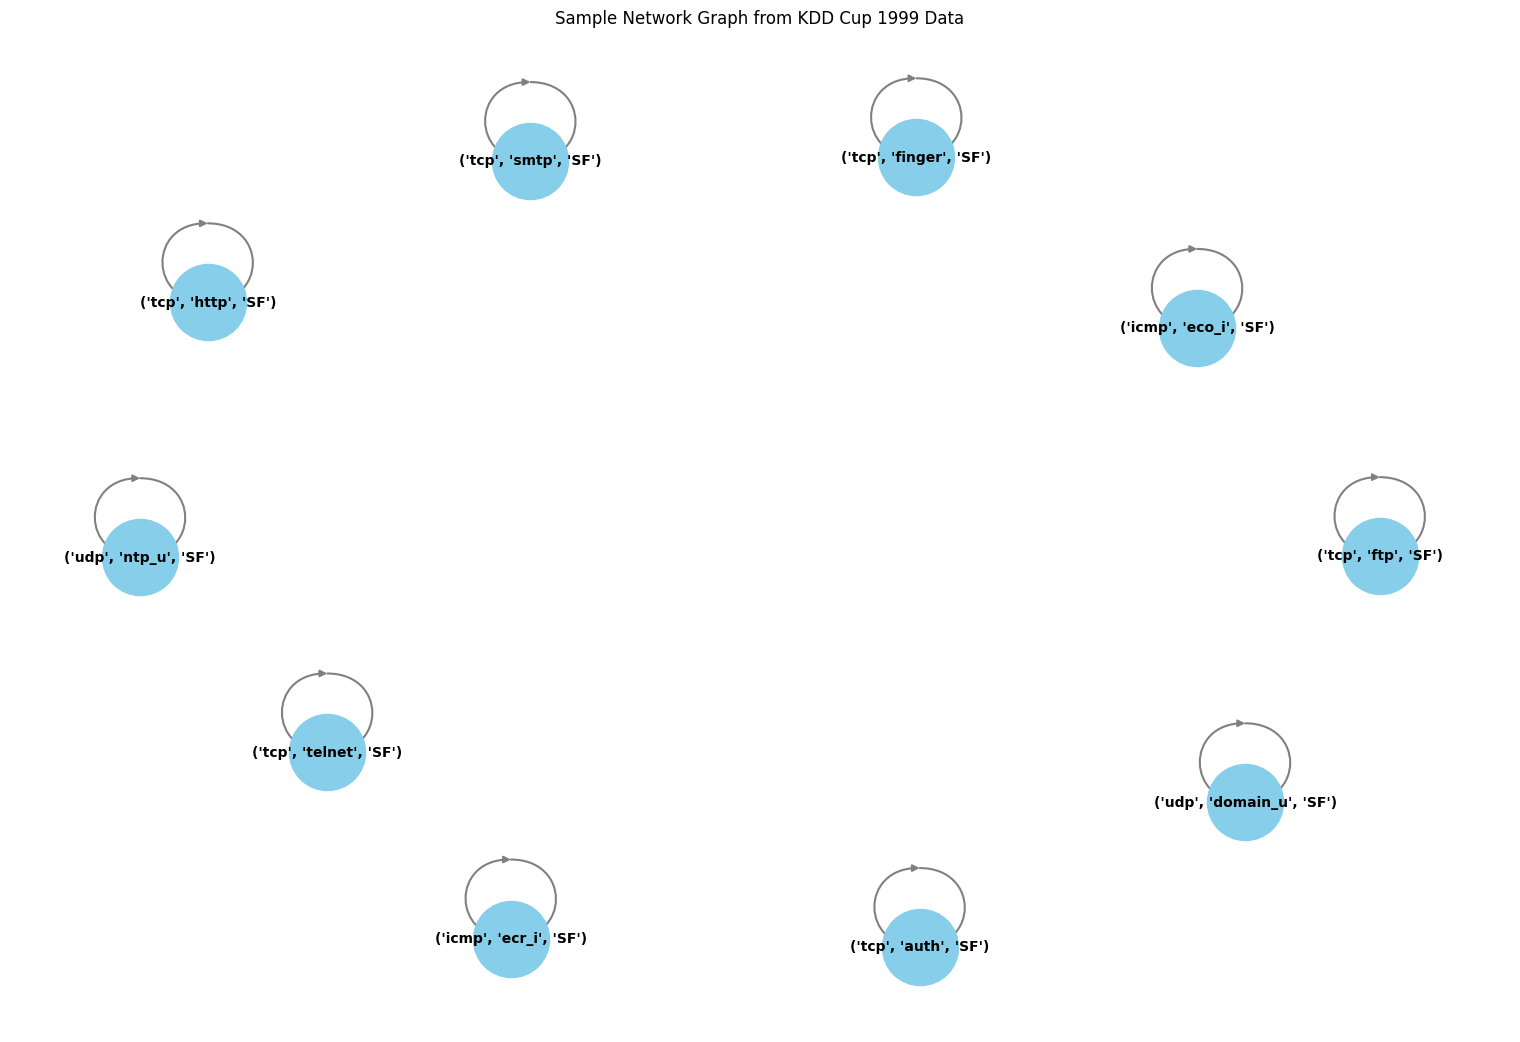

In [4]:
# Plot the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", width=1.5, edge_color="gray")
plt.title("Sample Network Graph from KDD Cup 1999 Data")
plt.show()

Here's the visual representation of the sample graph we constructed from the initial 1000 records of the KDD Cup 1999 dataset. Each node represents a unique combination of protocol_type, service, and flag. The edges represent connections based on the records in the dataset, with the weight (not shown here) corresponding to the src_bytes.

### Let's create a graph using the entire dataset:

In [5]:
# Create a directed graph for the entire dataset
G_full = nx.DiGraph()

# Add edges to the graph based on the records in the dataset
for index, row in data.iterrows():
    source = (row["protocol_type"], row["service"], row["flag"])
    target = (row["protocol_type"], row["service"], row["flag"])  # same as source since we're defining nodes in this manner
    G_full.add_edge(source, target, weight=row["src_bytes"])  # using src_bytes as weight for simplicity

# Number of nodes and edges in the full graph
len(G_full.nodes()), len(G_full.edges())

(210, 210)

The graph for the entire dataset consists of 210 unique nodes and 210 edges. Each node again represents a unique combination of protocol_type, service, and flag.

Now, let's attempt to visualize this graph. Given the increased size and potential overlap of nodes, this might be computationally intensive. If it takes too long or is unfeasible here, I'll provide you with the code to run on your local machine. Let's give it a try.

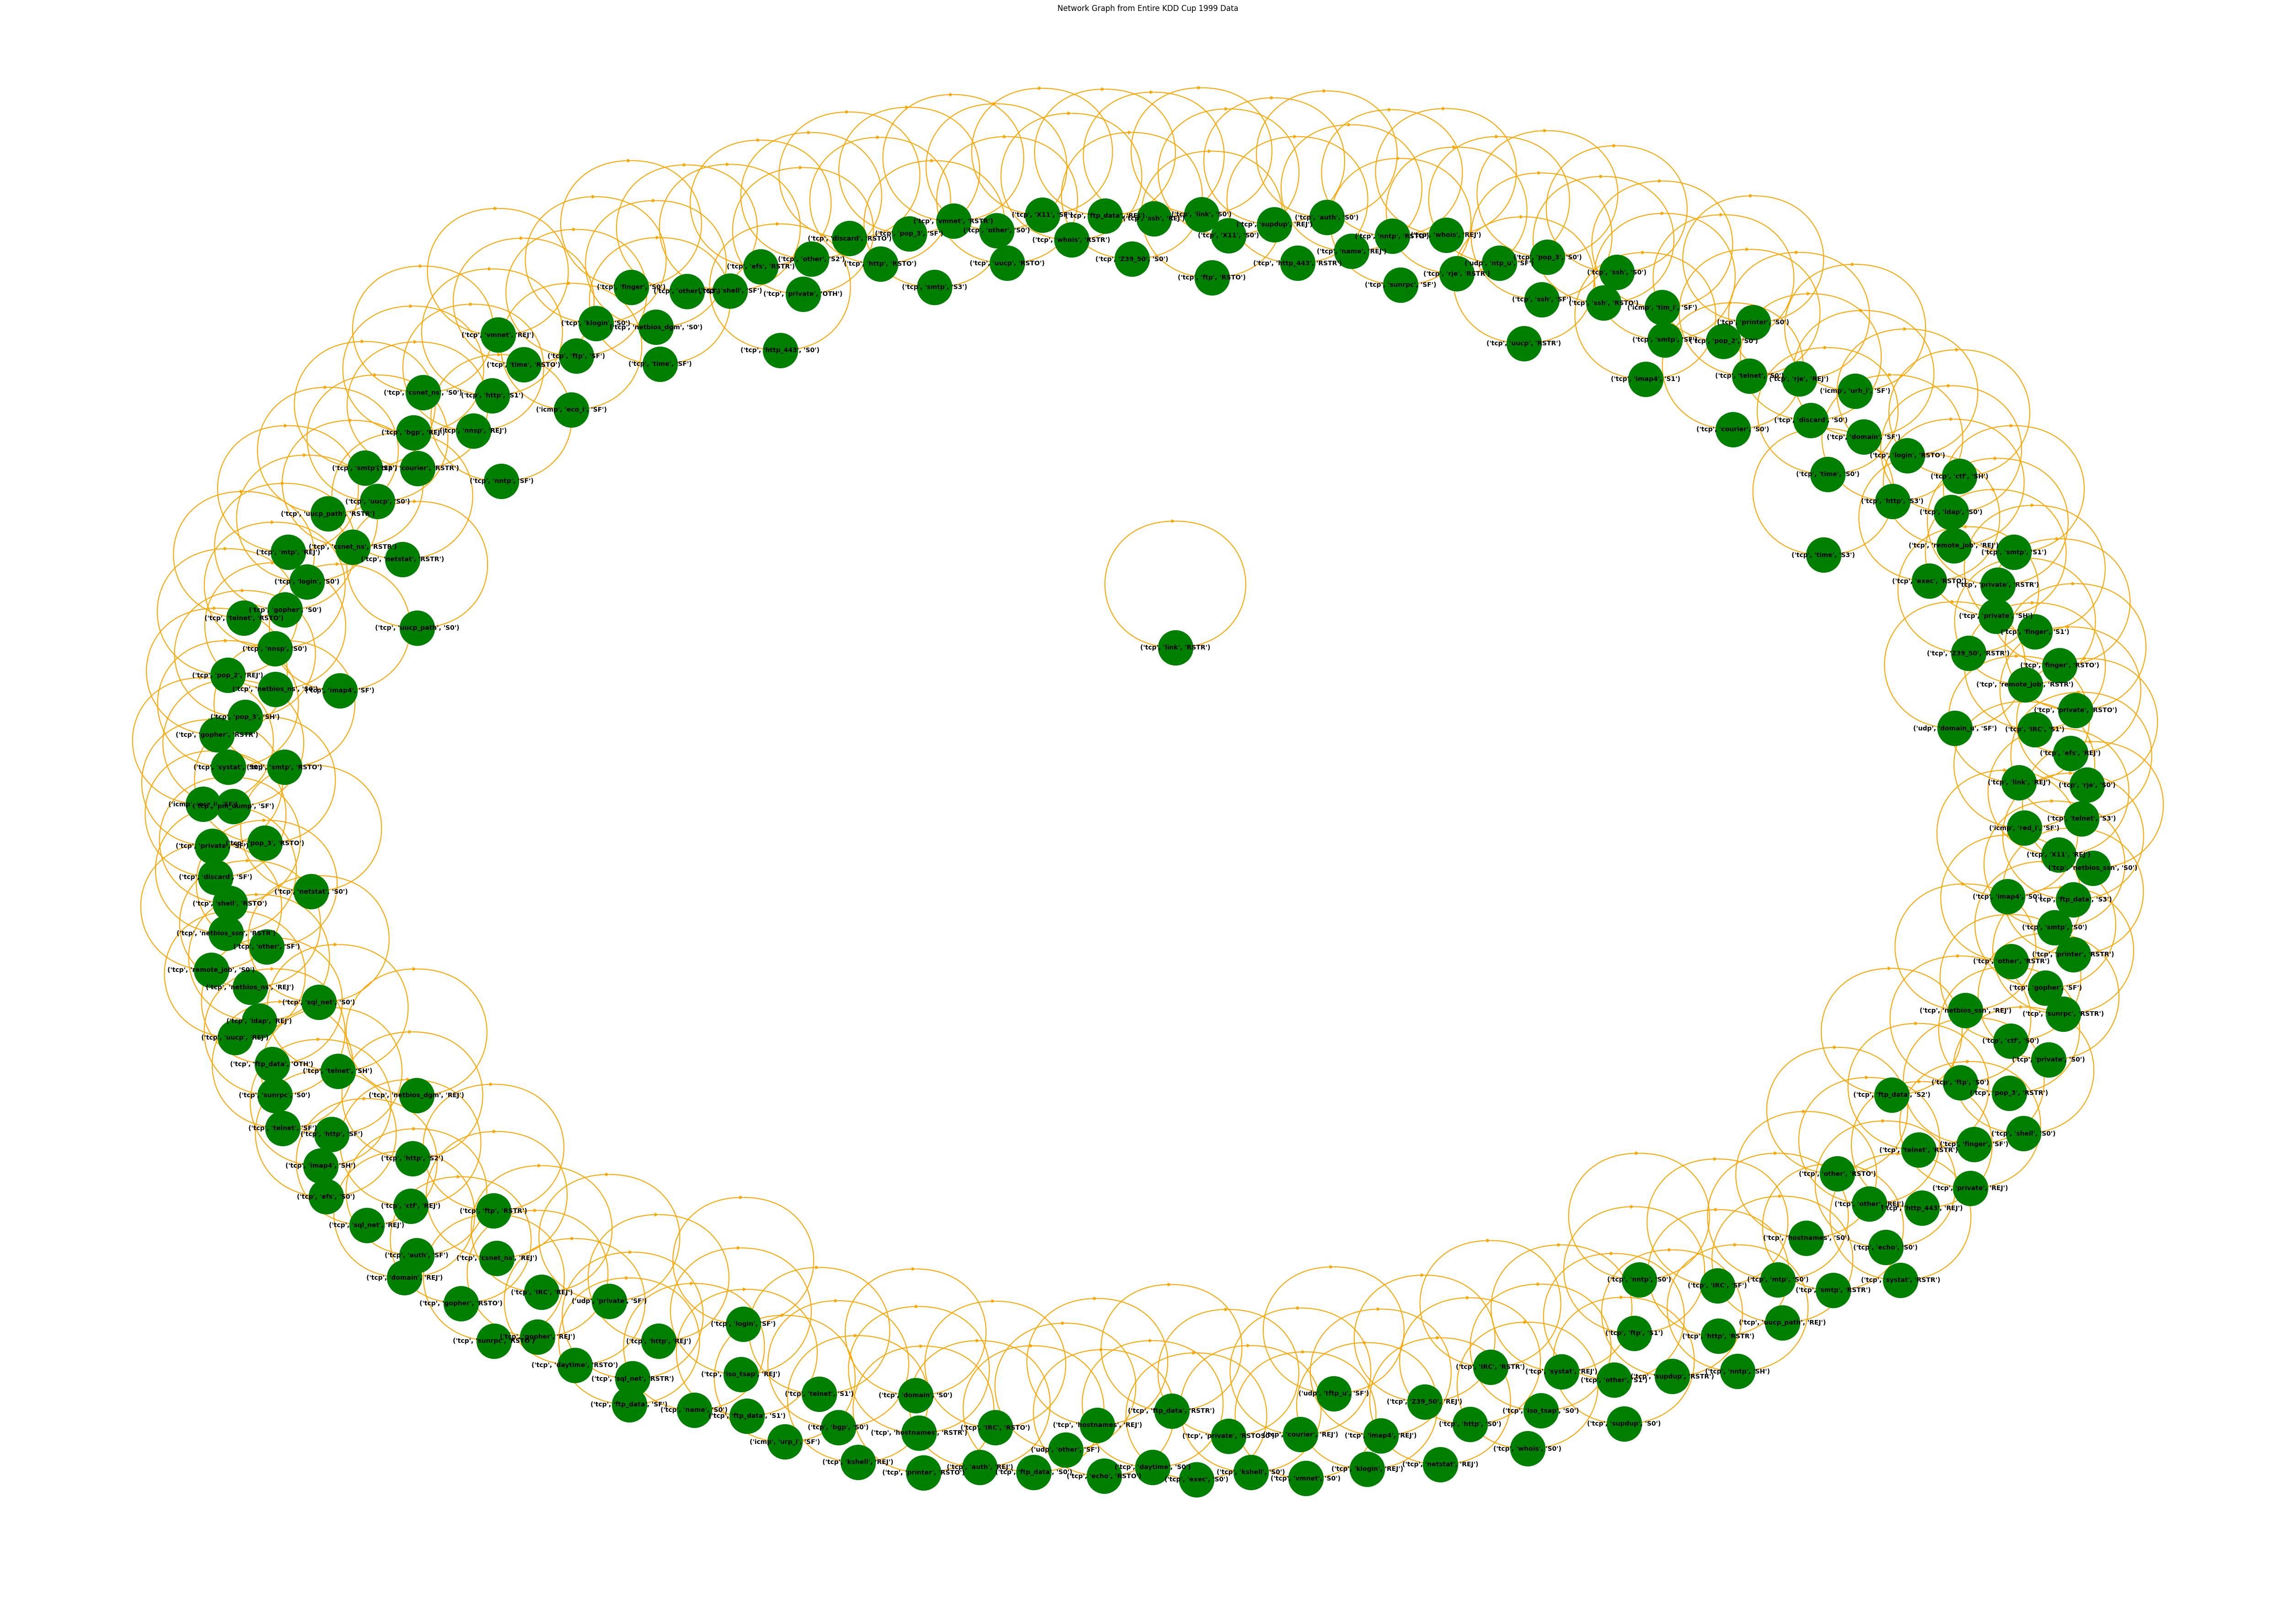

In [6]:
# Try plotting the graph for the entire dataset
plt.figure(figsize=(50, 35))
pos_full = nx.spring_layout(G_full)
nx.draw(G_full, pos_full, with_labels=True, node_size=3000, node_color="green", font_size=10, font_weight="bold", width=1.5, edge_color="orange")
plt.title("Network Graph from Entire KDD Cup 1999 Data")
plt.show()

Here's the visual representation of the graph constructed from the entire KDD Cup 1999 dataset (10% version). As before, each node represents a unique combination of protocol_type, service, and flag. The edges represent connections based on the records in the dataset

# Step 3: Making the Graph Dynamic

A dynamic graph essentially captures the evolution of the graph over time. While the KDD dataset doesn't have explicit timestamps, we can simulate a dynamic graph by segmenting the dataset into intervals and creating a graph snapshot for each interval.

#### 3.1 Segmenting the Dataset

Let's divide the dataset into intervals. For demonstration purposes, we can segment the data every 10,000 records to create multiple graph snapshots. This will give us a sequence of graphs, and we can observe how the graph evolves as we move through the dataset.

#### 3.2 Creating Graph Snapshots

For each interval, we'll generate a graph snapshot using the same method as before. Each graph snapshot represents the state of the network during that interval.

#### 3.3 Visualization

We'll visualize a few of these snapshots to understand the evolution of the graph over time.

Let's start by segmenting the dataset and creating the graph snapshots.

In [7]:
# Define interval size
interval_size = 10000

# Number of intervals (snapshots) based on the dataset size and interval size
num_intervals = len(data) // interval_size

# Create a list to store graph snapshots
graph_snapshots = []

# Create graph snapshots for each interval
for i in range(num_intervals):
    subset = data.iloc[i*interval_size : (i+1)*interval_size]
    G_interval = nx.DiGraph()

    for _, row in subset.iterrows():
        source = (row["protocol_type"], row["service"], row["flag"])
        target = (row["protocol_type"], row["service"], row["flag"])
        G_interval.add_edge(source, target, weight=row["src_bytes"])

    graph_snapshots.append(G_interval)

# Number of graph snapshots created
len(graph_snapshots)

49

To visualize the evolution, I am picking a few representative snapshots from the sequence, such as the first, middle, and last snapshots. This will give you an idea of how the network changes over time.

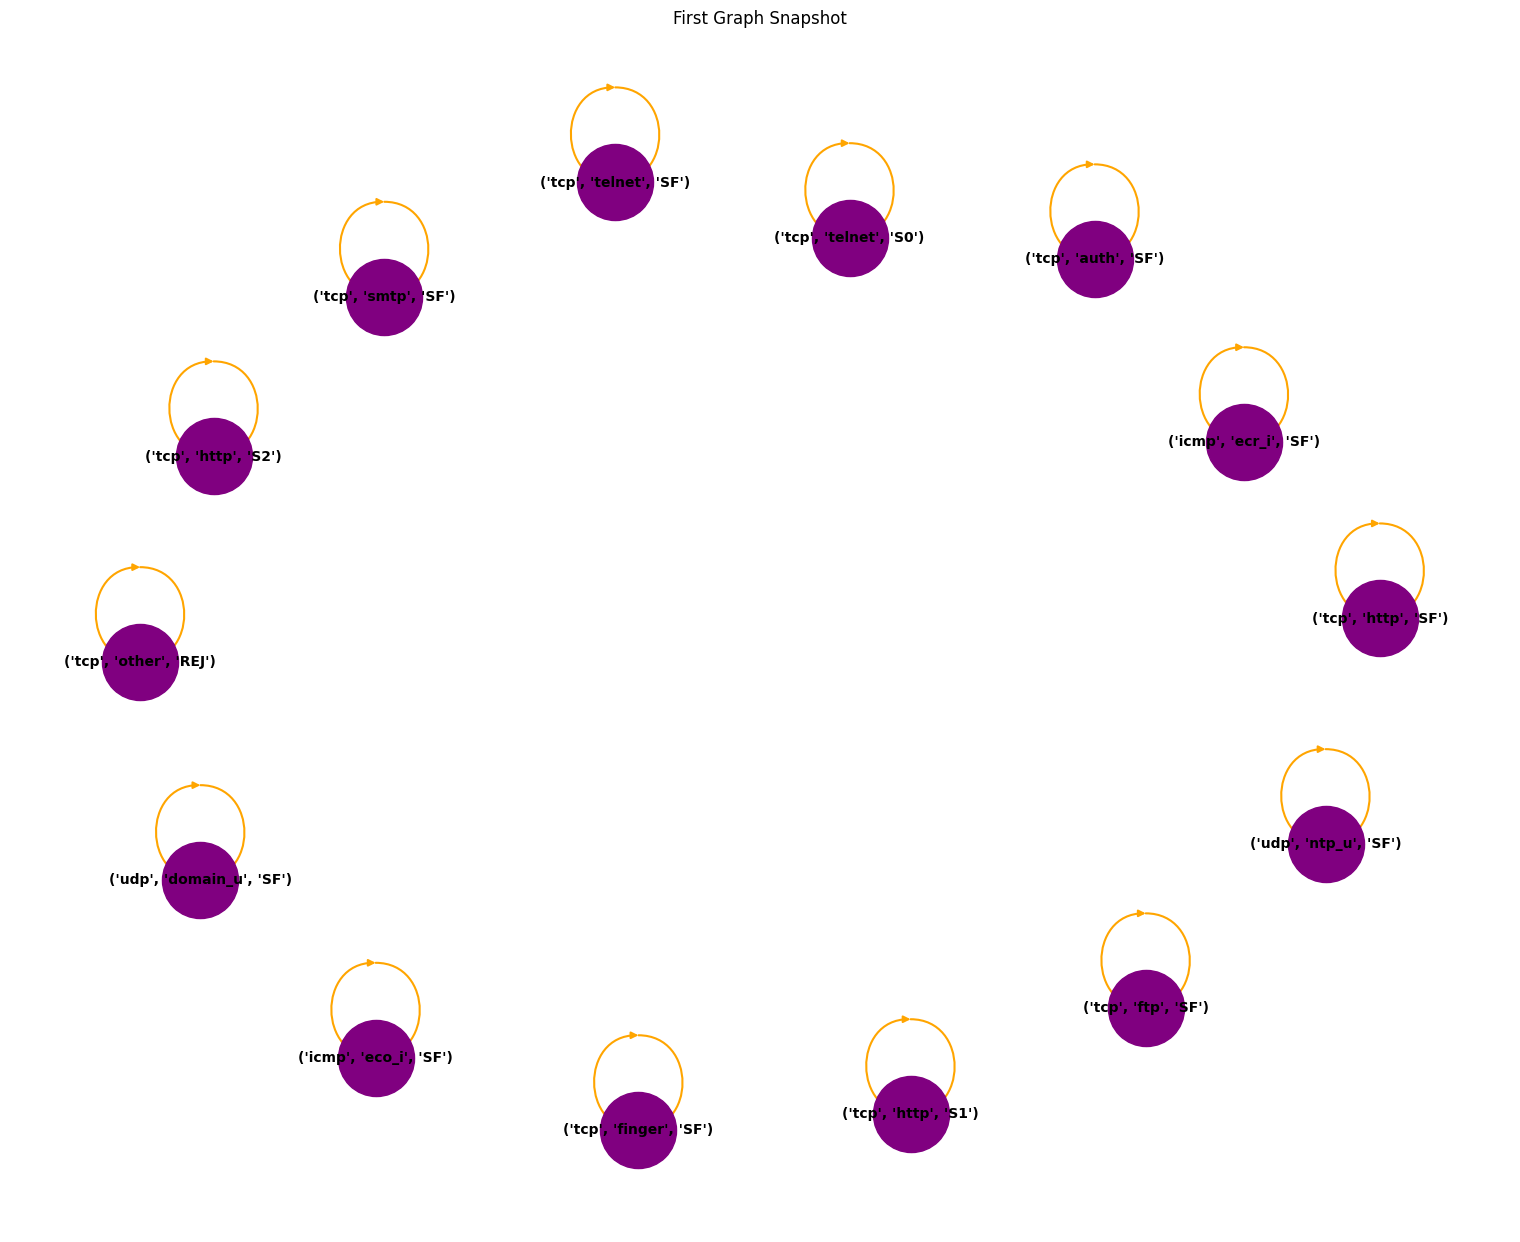

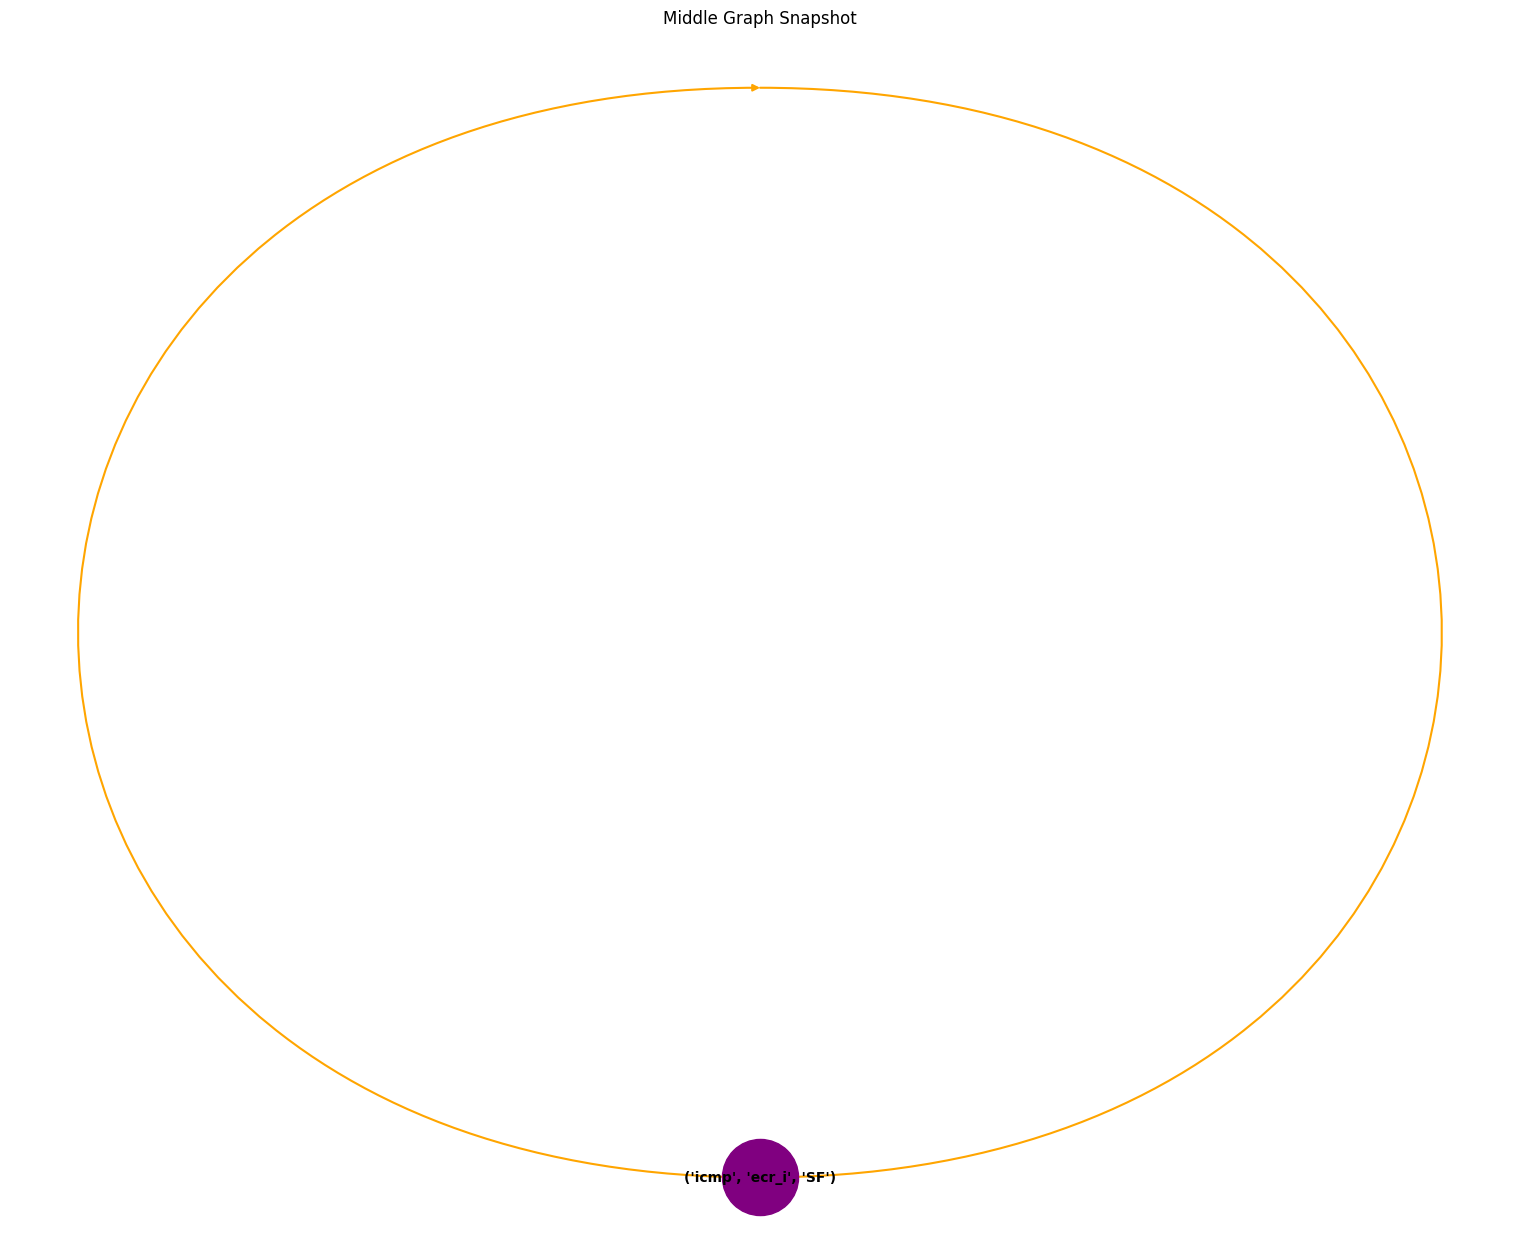

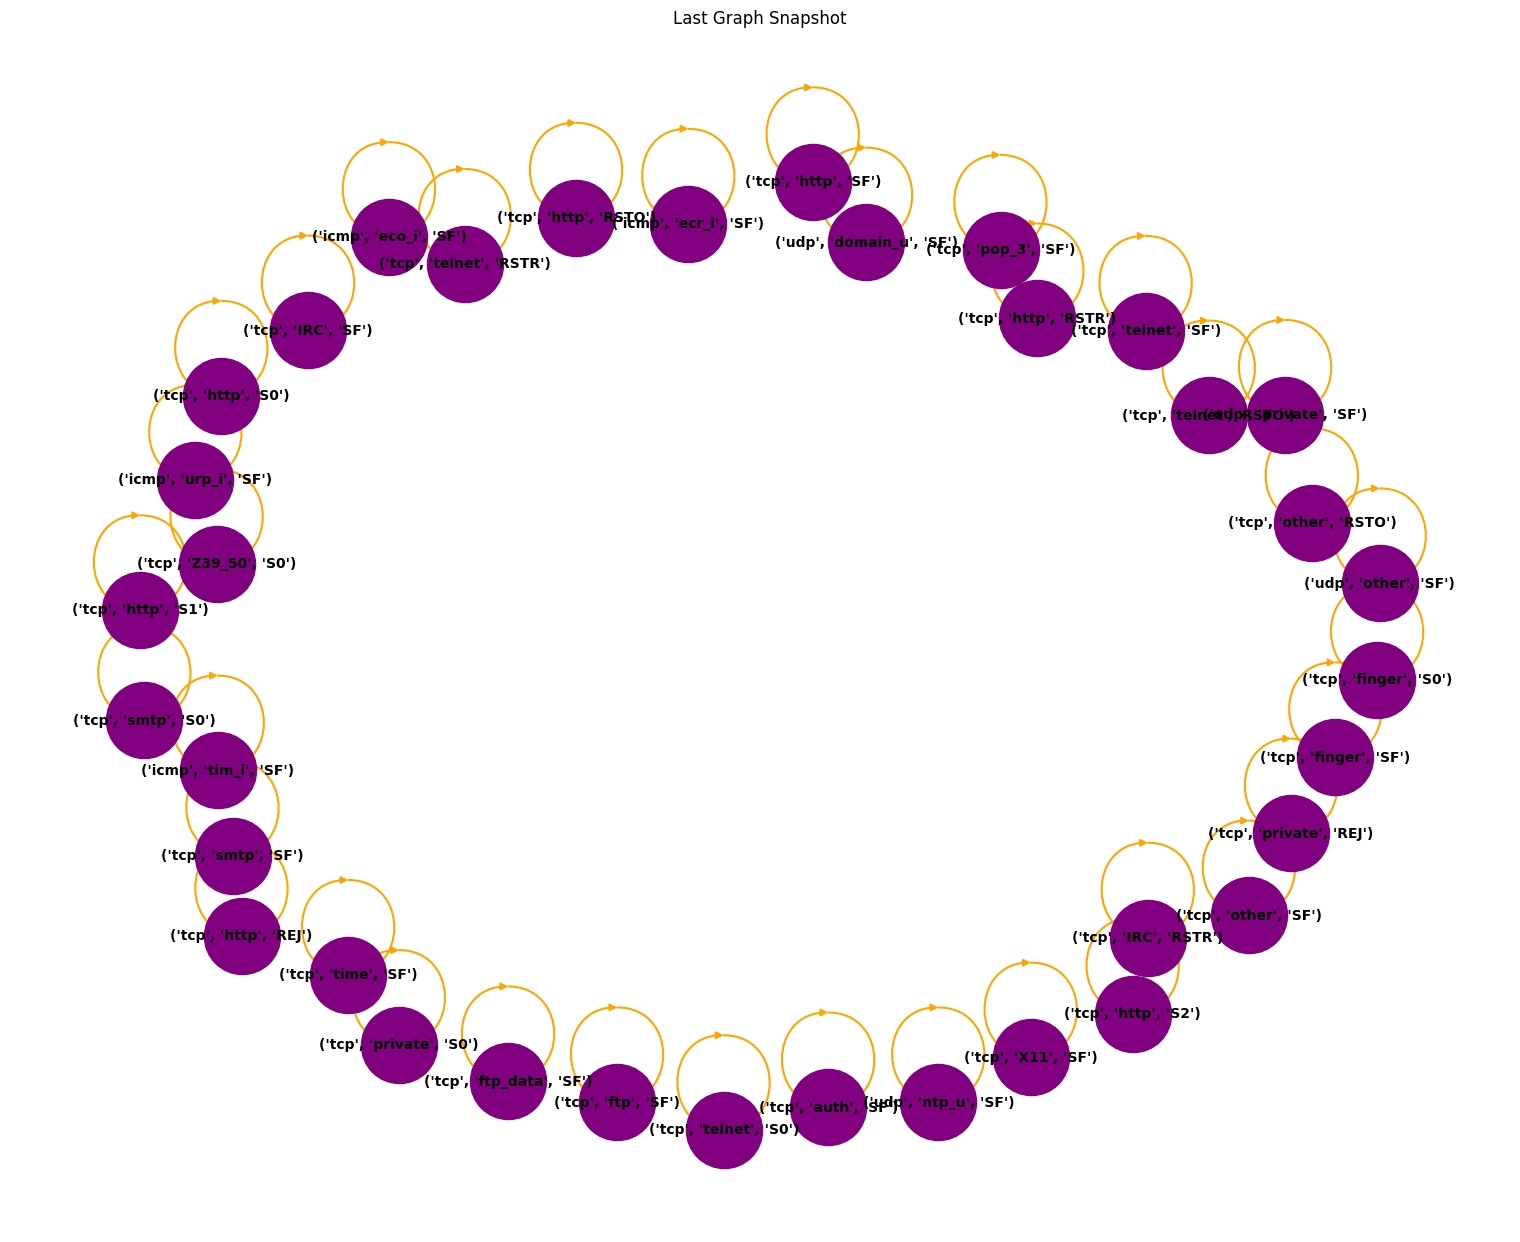

In [8]:
def plot_graph_snapshot(G, title):
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="purple", font_size=10, font_weight="bold", width=1.5, edge_color="orange")
    plt.title(title)
    plt.show()

# Visualize the first, middle, and last snapshots
plot_graph_snapshot(graph_snapshots[0], "First Graph Snapshot")
plot_graph_snapshot(graph_snapshots[len(graph_snapshots) // 2], "Middle Graph Snapshot")
plot_graph_snapshot(graph_snapshots[-1], "Last Graph Snapshot")

# Step 4: Generating Dynamic Graph Embeddings using DeepWalk

DeepWalk is a graph embedding technique that generates embeddings by simulating random walks on a graph. The embeddings are learned in a manner similar to word embeddings in natural language processing, where sequences of nodes from random walks are treated like sentences.

For dynamic graphs, we'll generate embeddings for each snapshot to capture the evolution of the graph over time.

#### 4.1 DeepWalk Algorithm:

The basic steps involved in the DeepWalk algorithm are as follows:

1. **Random Walks**: Perform random walks on the graph to generate sequences of nodes. Each random walk starts from a randomly chosen node and traverses the graph for a fixed number of steps.
2. **Skip-Gram Model**: Use the node sequences from the random walks as input to a Skip-Gram model (similar to Word2Vec) to generate embeddings for each node.

#### 4.2 Dynamic Embeddings:

For dynamic graph embeddings, repeat the DeepWalk process for each graph snapshot. This will give a sequence of embeddings representing the evolution of nodes over time.

#### 4.3 Visualization:

After obtaining the embeddings, we can use dimensionality reduction techniques, such as t-SNE or PCA, to visualize them in 2D space.

Let's start with generating embeddings for the first graph snapshot using DeepWalk. We'll use the `node2vec` implementation (which generalizes DeepWalk) for this purpose.

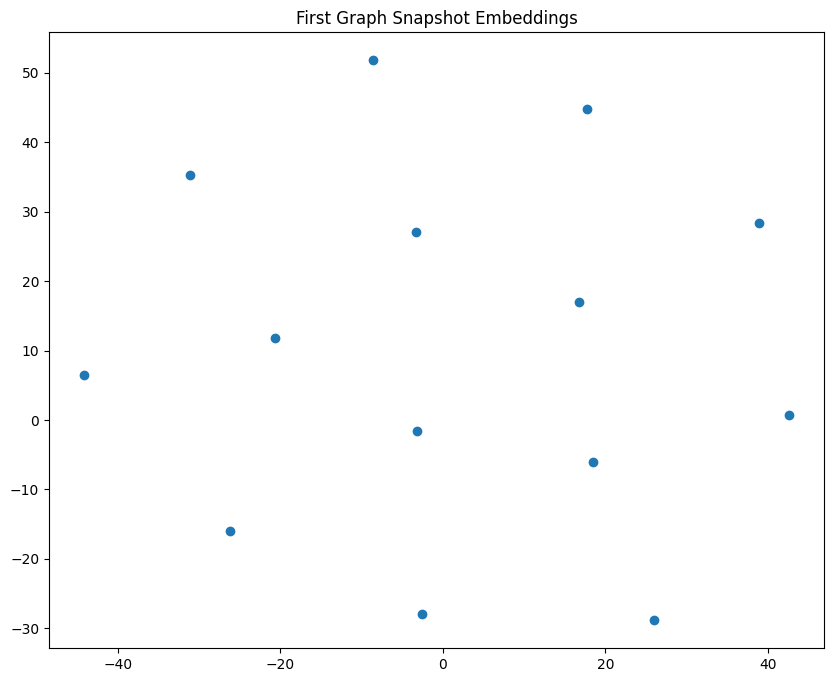

Skipping visualization for 'Middle Graph Snapshot Embeddings' due to insufficient unique nodes.


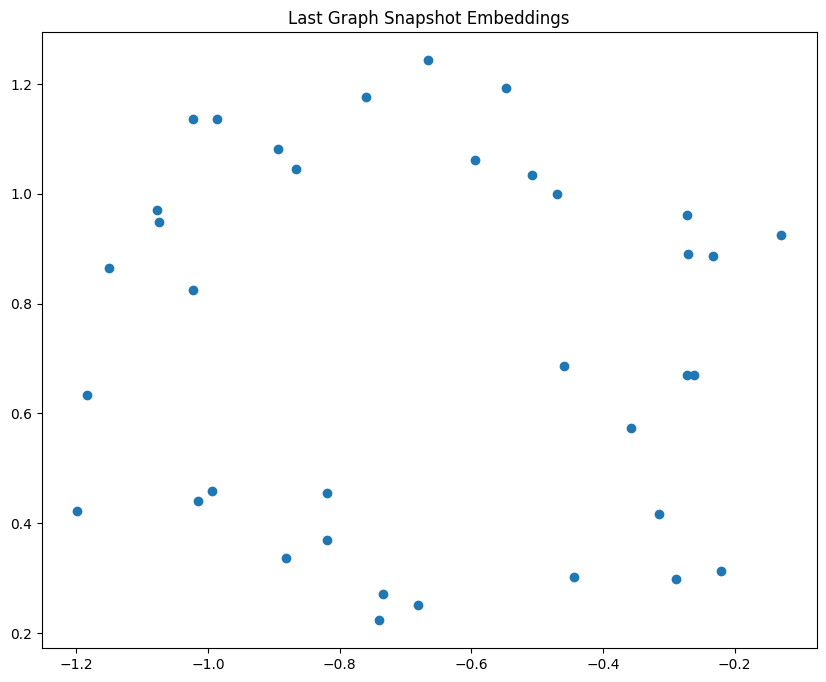

In [9]:
def generate_random_walks(G, num_walks, walk_length):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = [str(node)]
            current_node = node
            for _ in range(walk_length - 1):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                current_node = random.choice(neighbors)
                walk.append(str(current_node))
            walks.append(walk)
    return walks


def generate_embeddings(graph_snapshots, dimensions=64, walk_length=30, num_walks=200, window=10):
    all_embeddings = []
    for G in graph_snapshots:
        walks = generate_random_walks(G, num_walks, walk_length)
        model = Word2Vec(walks, vector_size=dimensions, window=window, min_count=0, sg=1, workers=4, epochs=5)
        embeddings = {node: model.wv[str(node)] for node in G.nodes()}
        all_embeddings.append(embeddings)
    return all_embeddings


# Generate the embeddings
all_embeddings = generate_embeddings(graph_snapshots)

# Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, title):
    nodes = list(embeddings.keys())
    features = np.array(list(embeddings.values()))

    # If only one unique node, skip visualization for this snapshot
    if len(nodes) <= 1:
        print(f"Skipping visualization for '{title}' due to insufficient unique nodes.")
        return

    # Adjust perplexity based on number of nodes
    perplexity_value = min(30, len(nodes) - 1)

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    embeddings_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    plt.title(title)
    plt.show()

# Visualize embeddings for the first, middle, and last snapshots
visualize_embeddings(all_embeddings[0], "First Graph Snapshot Embeddings")
visualize_embeddings(all_embeddings[len(all_embeddings) // 2], "Middle Graph Snapshot Embeddings")
visualize_embeddings(all_embeddings[-1], "Last Graph Snapshot Embeddings")

In [10]:
all_embeddings

[{('tcp',
   'http',
   'SF'): array([-0.3308172 ,  0.04735338,  0.8813851 ,  0.07048893, -0.4428355 ,
         -0.6862226 , -0.12025473, -0.2171129 ,  0.66985226, -0.37239614,
          0.25720605, -0.09922906,  0.15892439, -0.22159322, -0.81104094,
         -0.40809304, -0.16270764,  0.28022522,  0.06332812, -0.29396015,
         -0.16996387,  0.50323296,  0.06967666,  0.19118701, -0.6822617 ,
          1.0696284 , -0.5840048 ,  0.2165871 , -0.57679313, -0.7563144 ,
          0.08593996, -0.34186807, -1.241012  ,  0.20743221, -0.50390357,
          0.5024474 ,  0.84777755,  0.0382493 ,  0.24284819,  0.23149261,
          0.57804054,  0.04399611, -0.5229142 , -0.66523707,  0.83651626,
         -0.27715513, -0.37402502,  0.08656591,  0.48399803, -1.1777762 ,
         -0.3431747 ,  0.43438378, -0.7475954 ,  0.8826031 ,  0.47848296,
          0.0972826 ,  0.7354963 , -0.03781244, -0.94996834,  0.6625905 ,
          0.20816499, -0.02221331, -0.1868205 ,  0.64849025], dtype=float32),
  ('t

In [10]:
# This step is to combine the protocol_type, service, and flag attributes to create a unique identifier for each node.
data['node'] = data['protocol_type'] + "_" + data['service'] + "_" + data['flag']

# Modelling

## 1. Preparing the dataset

### 1. Handling Imbalanced Data:
The dataset is imbalanced, with a higher proportion of "normal" connections compared to "anomalous" connections. We can handle this by:

Undersampling: Reduce the number of "normal" samples.
Oversampling: Increase the number of "anomalous" samples.
SMOTE (Synthetic Minority Over-sampling Technique): Generate synthetic samples in the feature space.

To apply SMOTE:

1. Convert categorical features to numerical format using one-hot encoding.
2. Split the dataset into features (X) and labels (y).
3. Apply SMOTE to the training data to balance the classes.
Let's start with the first step: converting categorical features to numerical format using one-hot encoding. After that, we'll apply SMOTE.

In [11]:
# Check for null columns
data.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

As you can see in the above output, there is no missing values in any feature in the dataset.

#### Step 1: Labeling:
The KDD Cup 1999 dataset provides a variety of attack types. For simplicity in anomaly detection, we can consider all types of attacks as "anomalous" and the normal connections as "normal". This makes our task a binary classification problem.

Convert the labels into a binary format:
"normal" remains "normal"
All other labels (different attack types) become "anomalous"

In [12]:
# Convert labels to binary: "normal" or "anomalous"
data['label_binary'] = data['label'].apply(lambda x: 'normal' if x == 'normal.' else 'anomalous')

#### Step 2: Feature Extraction:
The embeddings generated from the previous step will be used as features.

In [13]:
data.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'node', 'label_binary'],
      dtype='object')

In [14]:
# Extracting features and labels
# For this example, we'll use embeddings from the first graph snapshot
# In practice, you might want to generate features dynamically for each snapshot
features = np.array([all_embeddings[0][node] for node in data['node'] if node in all_embeddings[0]])
labels = data[data['node'].isin(all_embeddings[0])]['label_binary'].values

#### Step 3: Convert Categorical Features to Numerical Format
The KDD Cup 1999 dataset has categorical attributes such as `protocol_type`, `service`, and `flag`. These can be converted to a numerical format using one-hot encoding.

In [15]:
# Convert categorical attributes to one-hot encoded columns
data_encoded = pd.get_dummies(data, columns=['protocol_type', 'service', 'flag'])

#### Step 4: Split the Dataset into Features and Labels
Before applying SMOTE, let's split our data into features (X) and labels (y).

In [16]:
X = data_encoded.drop(columns=['label', 'label_binary', 'node'])
y = data_encoded['label_binary']

#### Step 5: Apply SMOTE to Balance the Classes
Apply SMOTE to balance out the class distribution:

In [17]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#### Step 6: Model Training

For this example, we'll use the Random Forest Classifier, a versatile and commonly used model for classification tasks, including anomaly detection.


##### 1. Splitting the Dataset:
Before training, you should split the resampled data into training and testing subsets. This ensures you have a separate set to evaluate the model's performance.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

##### 2. Training the Model:

In [19]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##### Model Testing and Evaluation

In [21]:
# Make the predictions
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Convert string labels to binary numeric format for ROC-AUC computation
y_test_numeric = [0 if label == 'normal' else 1 for label in y_test]
y_pred_numeric = [0 if label == 'normal' else 1 for label in y_pred]

# Compute the ROC-AUC score
roc_auc = roc_auc_score(y_test_numeric, y_pred_numeric)

print("ROC-AUC Score:", roc_auc)

Accuracy: 0.9998991791502483

Classification Report:
               precision    recall  f1-score   support

   anomalous       1.00      1.00      1.00    119167
      normal       1.00      1.00      1.00    118879

    accuracy                           1.00    238046
   macro avg       1.00      1.00      1.00    238046
weighted avg       1.00      1.00      1.00    238046

ROC-AUC Score: 0.9998992704864004


# Modelling - 2

### Check the class imbalance

In [31]:
# Check class distribution in 'data' DataFrame
class_distribution = data['label_binary'].value_counts()
print(class_distribution)

label_binary
anomalous    396743
normal        97278
Name: count, dtype: int64


In [32]:
data.head()

duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                     0.0   
1               0       0    0  ...                     0.0   
2               0       0    0  ...                     0.0   
3               0       0    0  ...                     0.0   
4               0       0    0  ...                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   
1                         0.05                          0.0   
2                         0.03                          0.0   
3                         0.03                          0.0   
4                         0.02                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   
1                   0.0                       0.0                   0.0   
2                   0.0                       0.0                   0.0   
3                   0.0                       0.0                   0.0   
4                   0.0                       0.0                   0.0   

   dst_host_srv_rerror_rate    label         node  label_binary  
0                       0.0  normal.  tcp_http_SF        normal  
1                       0.0  normal.  tcp_http_SF        normal  
2                       0.0  normal.  tcp_http_SF        normal  
3                       0.0  normal.  tcp_http_SF        normal  
4                       0.0  normal.  tcp_http_SF        normal  

[5 rows x 44 columns]

The class distribution indicates that the dataset is imbalanced with a significantly larger number of "anomalous" samples compared to "normal" samples.

However, Isolation Forest is designed specifically for anomaly detection and is generally robust to class imbalances. Therefore, we can proceed without resampling the dataset in this case.

## Hyperparameter Tuning for Isolation Forest using RandomizedSearchCV

#### 1. **Set the Hyperparameter Grid**:
For the Isolation Forest, some of the important hyperparameters are:
- `n_estimators`: The number of base estimators (trees) in the ensemble.
- `max_samples`: The number of samples to draw from the dataset to train each base estimator.
- `contamination`: The proportion of outliers in the dataset.
- `max_features`: The number of features to draw from the dataset to train each base estimator.

We'll define a range for each of these hyperparameters.

#### 2. **Apply RandomizedSearchCV**:
`RandomizedSearchCV` performs a random search over specified hyperparameter values using cross-validation. It's faster than an exhaustive search (like GridSearchCV) because not all parameter values are tried out.

#### 3. **Train and Evaluate the Best Model**:
After hyperparameter tuning, we'll use the best parameters to train our model and then evaluate its performance.

Let's proceed step by step:

### Step 1: Define the Hyperparameter Grid

In [33]:
# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_samples': ['auto', 128, 256, 512, 1024],
    'contamination': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_features': [0.5, 0.7, 0.9, 1.0],
    'bootstrap': [True, False]
}

In [34]:
# Convert categorical attributes to one-hot encoded columns
data_encoded = pd.get_dummies(data, columns=['protocol_type', 'service', 'flag'])

# Convert 'label_binary' to binary numeric format
data_encoded['label_binary'] = data_encoded['label_binary'].map({'normal': 0, 'anomalous': 1})

### Step 2: Apply RandomizedSearchCV

In [37]:
# Initialize IsolationForest and RandomizedSearchCV
iso_forest = IsolationForest()

# Create a custom F1-score metric with the 'binary' average setting
f1_scorer = make_scorer(f1_score, average='binary')

# Set up RandomizedSearchCV with the custom F1-score metric
random_search = RandomizedSearchCV(
    iso_forest,
    param_distributions=param_dist,
    n_iter=20,
    scoring=f1_scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(data_encoded.drop(columns=['label', 'label_binary', 'node']), data_encoded['label_binary'])

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/akashmanujayaliyanaarachchi/Documents/UWE/CSCT Masters Project/Dynamic-Graph-Embeddings-for-Real-Time-Anomaly-Detection-in-Network-Traffic/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_c

KeyboardInterrupt: 